## STEPS

gdf
- load in coastal tiles
- append to gdf HAT values
- append to gdf HAT + surge values

supratidal extent
- load in srtm (0-10), item (2-8), MrVBF (raf to give value), (mangrove?)
- combine and create binary mask

HAT
- xr.where srtm <= HAT value == 1, else leave srtm values

HAT+storm
- xr. where srtm >= HAT and <= HAT+storm
- select out as new var (for now)
- then normalise based on min (HAT) and max (HAT+storm)
- invert normalisation
- divide by 2 then add 0.5 to get 0.5 - 0.1 values

above HAT+storm
- xr. where srtm >= HAT+storm and <= 10m
- select out as new var (for now)
- then normalise based on min (HAT+storm) and max (10)
- invert normalisation
- divide by 2 to get 0 - 0.5

- merge back together (maybe just & function?)

connectivity
- make connectivity
- add layers together, then divide by 2 to get back to 0-1

multiply srtm output by connectivity output

In [1]:
%matplotlib inline

import sys
from osgeo import gdal
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
# pd.set_option('display.max_rows', None)

sys.path.insert(0, "/home/jovyan/code/dea-notebooks/Tools")
import datacube
from dea_tools.plotting import display_map
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
from datacube.testutils.io import rio_slurp_xarray
dc = datacube.Datacube()

sys.path.insert(1, "/home/jovyan/code/xarray-spatial")
from xrspatial.proximity import proximity


## user inputs: tile, time and export geotiffs?


In [2]:
# add time (not a range, just repeat year input here)
time_range = ("2020", "2020")

# export as geotiff?
export = True

### using GA coastal tiles geojson


In [3]:
# GA coastal tiles
vector_file = '../data/geojson/ga_summary_grid_c3_coastal.geojson'
attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)
mainland_grid = gdf[gdf['type'] == 'mainland']

id_list = []
for index, row in mainland_grid.iterrows():
    id_list.append(row['id'])
mainland_grid.explore()

### append HAT and HAT + storm surge ## TODO

In [4]:
# make this up for now as standard values until raf gives code
# add col for HAT at value of 3
mainland_grid['HAT'] = 3
# add col for surge at value of 7
mainland_grid['HAT_SS'] = 7

/env/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/env/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### select the tile of interest (click on map above and find value for `id` and manually select using `loc` below)

In [5]:
gdf = mainland_grid.loc[mainland_grid['id'] == 27]
gdf.explore()

In [6]:
# Create the 'query' dictionary object
res = (-30, 30)

query = {
    "time": time_range,
    'resolution':res}

In [7]:
# Loop through polygons in geodataframe and add geom to queries
for index, row in gdf.iterrows():
    print(f'Feature: {index + 1}/{len(gdf)}')
    
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

# Extracting specific keys from dictionary (removing time to load things like item and srtm)
query_notime = {key: query[key] for key in query.keys()
       & {'resolution', 'geopolygon'}}

Feature: 27/1


### load strm, item, mangroves, MrVBF
- maybe also do if else statement for other layers like mangrove?

In [30]:
# Load STRM
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_notime)
srtm = srtm_ds.dem_h

# Load item
item_ds = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_notime)
item = item_ds.relative

# Load in mangrove cover
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query)

# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)
    

# Load in MrVBF
geotiff_path = '/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/MrVBF_1_arc-second_resolution/mrvbf_int.tif'
# load in geotiff again but with identical extent from srtm
MrVBF = rio_slurp_xarray(geotiff_path, gbox=srtm.geobox)
MrVBF.attrs['crs'] = 'EPSG:3577'

### create supratidal extent mask

In [41]:
## wrangle binary maps and create supratidal mask

# SRTM
# greater than 0m AHD and less than 10m AHD == True
AHD_min = 0
AHD_max = 10

lessthan10m_AHD = srtm <= AHD_max
greaterthan0m_AHD = srtm >= AHD_min
AHD_threshold_srtm = lessthan10m_AHD & greaterthan0m_AHD

# MrVBF (mask class 0 30% Erosional, class 1 16% Small hillside deposit, class 2 8% Narrow valley floor)
MrVBF_mask = (MrVBF >= 3) & (item <= 9)

# not mangrove == True
not_mangrove = (1 - mangrove)
not_mangrove = not_mangrove == 1

# not exposed intertidal == True
# not_intertidal = item == 9
intertidal = (item >= 2) & (item <= 8)
not_intertidal = (1 - intertidal)

# remove time dims
AHD_threshold_srtm = AHD_threshold_srtm.squeeze('time')
MrVBF_mask = MrVBF_mask.squeeze('time')
not_mangrove = not_mangrove.squeeze('time')
not_intertidal = not_intertidal.squeeze('time')

In [43]:
# combine masks
# where its not mangrove or exposed intertidal, but is within 0-10m AHD and has low relief (MrVBF)
supratidal = xr.where((AHD_threshold_srtm == True) & (MrVBF_mask == True) & (not_mangrove == True) & (not_intertidal == True), 1, 0).astype('int8')

# Generate a polygon mask to keep only data within the polygon
mask = xr_rasterize(gdf, srtm_ds)

# Mask dataset to set pixels outside the polygon to `NaN`
supratidal_mask = supratidal.where(mask)

In [44]:
# get elevation values for supratidal_mask
supratidal_elev = srtm * supratidal_mask
supratidal_elev = xr.where(supratidal_elev == 0, np.nan, supratidal_elev.values)

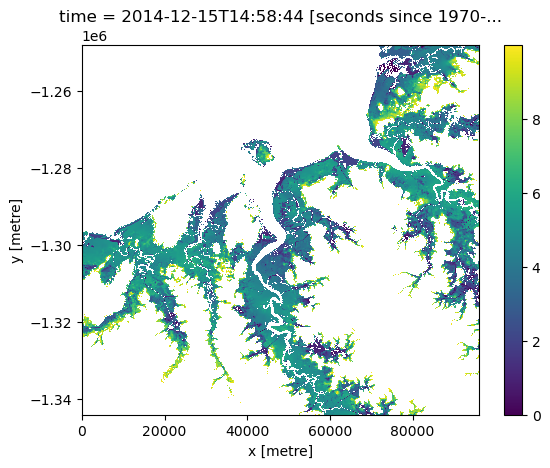

In [45]:
supratidal_elev.plot()

### generate elevation probability product
- values of 1 for <= HAT
- values normalised > HAT and <= HAT_SS
- values normalised > HAT_SS and <= 10m AHD

In [ ]:
HAT
- xr.where srtm <= HAT value == 1, else leave srtm values

HAT+storm
- xr. where srtm >= HAT and <= HAT+storm
- select out as new var (for now)
- then normalise based on min (HAT) and max (HAT+storm)
- invert normalisation
- divide by 2 then add 0.5 to get 0.5 - 0.1 values

above HAT+storm
- xr. where srtm >= HAT+storm and <= 10m
- select out as new var (for now)
- then normalise based on min (HAT+storm) and max (10)
- invert normalisation
- divide by 2 to get 0 - 0.5

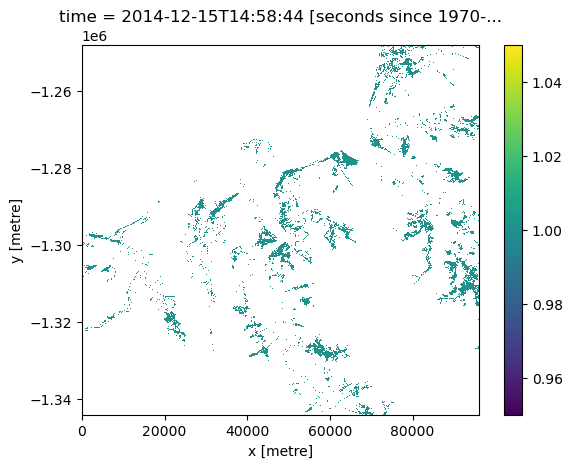

In [46]:
# HAT
HAT = xr.where(supratidal_elev <= gdf.HAT.values[0], 1, np.nan)
HAT.plot()

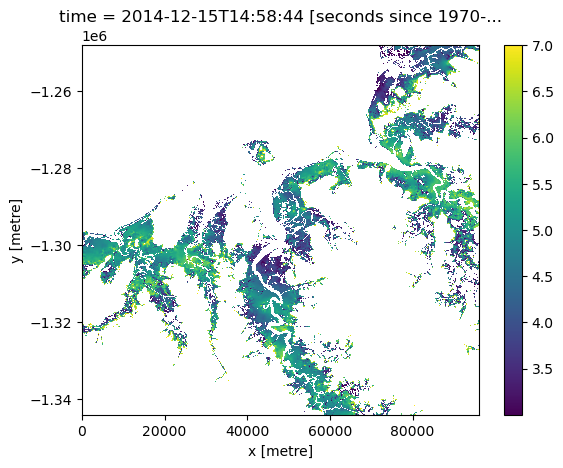

In [47]:
# HAT + storm
HAT_storm = xr.where((supratidal_elev > gdf.HAT.values[0]) & (supratidal_elev <= gdf.HAT_SS.values[0]), supratidal_elev.values, np.nan)
HAT_storm.plot()

In [50]:
# normalise between HAT and HAT_SS

# Find the minimum and maximum values in the data array
min_value = gdf.HAT.values[0]
max_value = gdf.HAT_SS.values[0]
print(f"Minimum Value: {min_value}")
print(f"Maximum Value: {max_value}")

# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
HAT_storm_norm = (HAT_storm - min_value) / (max_value - min_value)

# invert the normalisation and normalise between 0.5 and 1
HAT_storm_norm_05_1 = (((1 - HAT_storm_norm)/2) + 0.5)

Minimum Value: 3
Maximum Value: 7


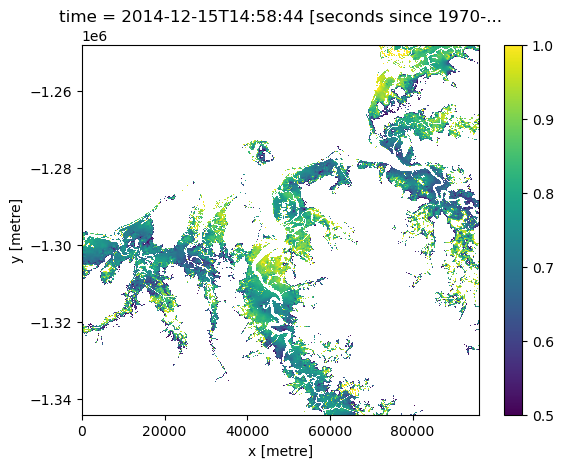

In [52]:
HAT_storm_norm_05_1.plot()

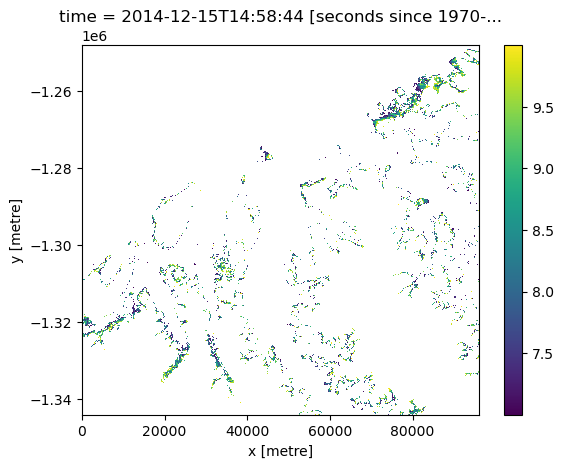

In [53]:
# HAT + storm
HAT_storm_10AHD = xr.where((supratidal_elev > gdf.HAT_SS.values[0]) & (supratidal_elev <= 10), supratidal_elev.values, np.nan)
HAT_storm_10AHD.plot()

In [54]:
# normalise between HAT_SS and 10m AHD

# Find the minimum and maximum values in the data array
min_value = gdf.HAT_SS.values[0]
max_value = 10
print(f"Minimum Value: {min_value}")
print(f"Maximum Value: {max_value}")

# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
HAT_storm_10AHD_norm = (HAT_storm_10AHD - min_value) / (max_value - min_value)

# invert the normalisation and normalise between 0.5 and 1
HAT_storm_10AHD_norm_05_0 = ((1 - HAT_storm_10AHD_norm)/2)

Minimum Value: 7
Maximum Value: 10


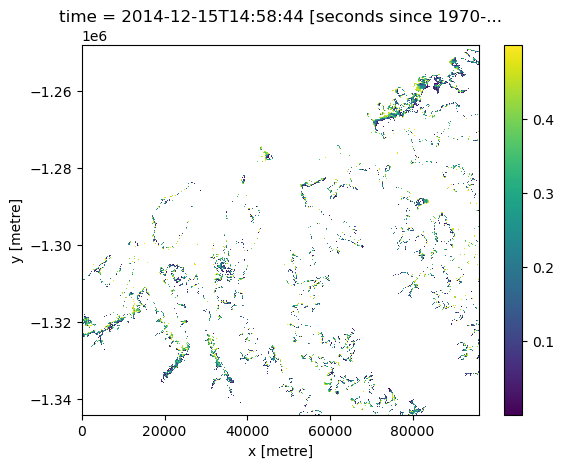

In [55]:
HAT_storm_10AHD_norm_05_0.plot()

In [68]:
supratidal_mask

<xarray.DataArray (y: 3201, x: 3200)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
  * y            (y) float64 -1.248e+06 -1.248e+06 ... -1.344e+06 -1.344e+06
  * x            (x) float64 15.0 45.0 75.0 ... 9.592e+04 9.596e+04 9.598e+04
    spatial_ref  int32 3577

In [70]:
# combine layers back together
supratidal_combine = ((HAT.fillna(0)) + (HAT_storm_norm_05_1.fillna(0)) + (HAT_storm_10AHD_norm_05_0.fillna(0))).squeeze('time')

# remove outside extent (make np.nan)
supratidal_elev_confidence_layer = xr.where(supratidal_mask == 1, supratidal_combine.values, np.nan)

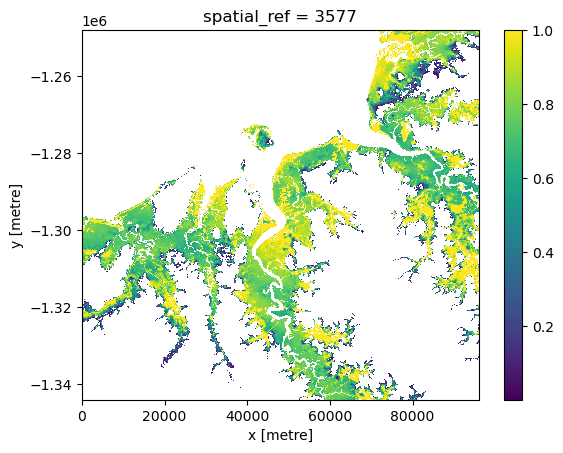

In [72]:
supratidal_elev_confidence_layer.plot()

In [ ]:
# export out layers for checking

# supratidal extent elevations
# HAT
# HAT_SS
# HAT_SS to 10m AHD
# supratidal_elev_confidence_layer

